# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [51]:
!pip install --upgrade pip

In [ ]:
!pip install -q tensorflow==2.3

In [54]:
#аугментации изображений
!pip install albumentations -q

In [194]:
# Importing modules.
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import albumentations
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import PIL
import cv2
import re

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pylab import rcParams
from itertools import combinations
from scipy.stats import ttest_ind

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [59]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [55]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [57]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [159]:
train.head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый,1
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый,1
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый,1


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [60]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [61]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

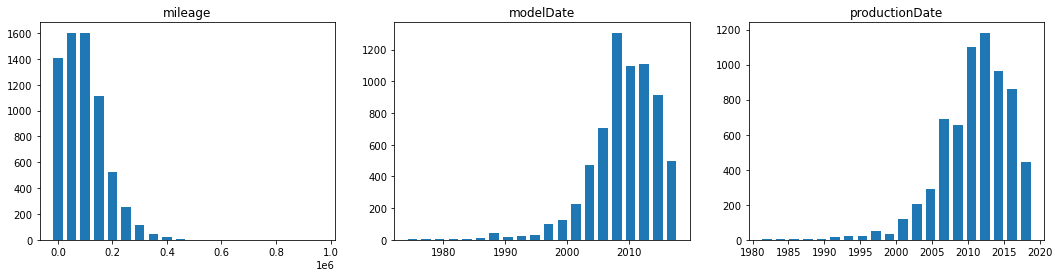

In [62]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [63]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [64]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


#### Посмотрим на корреляцию численных признаков
потенциально у нас должна быть зависимость между датой производства автомобиля и датой выпуска автомобиля. Обработаем данную зависимость далее.

In [65]:
import seaborn as sns

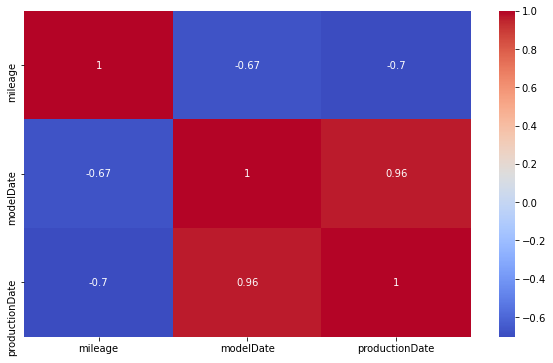

In [66]:
correlation = data[numerical_features].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

#### При обработке исходного датасета произведем следующие операции:
- Убираем лишние столбцы
- Логнормируем числовые признаки
- Удаляем коррелирующие числовые признаки
- Сделаем числовой признак с объемом двигателя (из engineDisplacement)
- Сделаем числовой признак с количеством л.с. автомобиля (из enginePower)
- Сделаем числовой признак с возрастом автомобиля (из ProductionDate)
- Сделаем числовой признак среднегодового пробега
- Нормализуем данные
- Сделаем Label и OneHot кодирование признаков
- Заполним Nan средним значением

In [144]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    
    df_output.drop([
        'description',
        'name',
        'sell_id',
        'Владение',
        'Руль'
    ], axis = 1, inplace=True)
    # логнормируем числовые признаки
    df_output.mileage = np.log(df_output['mileage'] + 1)
    df_output.modelDate = np.log(df_output['modelDate'] + 1)
    df_output.productionDate = np.log(df_output['productionDate'] + 1)
    # удаляем один из коррелирующих признаков modelDate и productionDate
    #df_output.drop(['modelDate'], axis = 1, inplace=True)
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    # Сделаем числовой признка из engineDisplacement
    df_output['engineDisplacement_N'] = df_output['engineDisplacement'].apply(lambda x:
                                                                           x[:x.find(' LTR')])
    
    df_output['engineDisplacement_N'] = df_output['engineDisplacement_N'].apply(lambda x: float(x) if len(x)<4 else 0)
    
    # Сделаем числовой признка из enginePower
    df_output['enginePower_N'] = df_output['enginePower'].apply(lambda x: int(x[:x.find(' N12')]))
    
    df_output['how_old'] = df_output['productionDate'].apply(lambda x: pd.Timestamp.today().year - x)
    df_output['mile_per_year'] = df_output['mileage'] / df_output['how_old']

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    #df_output['how_old'] = df_output['productionDate'].apply(lambda x: pd.Timestamp.today().year - x)
    #df_output['mile_per_year'] = df_output['mileage'] / df_output['how_old']
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [145]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.head(10)

,mileage,modelDate,productionDate,sample,price,engineDisplacement_N,enginePower_N,how_old,mile_per_year,bodyType_0,...,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
0,0.919998,0.273217,0.238563,0,0.0,3.0,220,2013.403106,0.006340,0,...,0,0,0,0,1,0,1,1,0,0
1,0.679963,0.834995,0.817210,0,0.0,3.0,313,2013.392122,0.004776,0,...,0,0,1,0,0,0,1,0,0,1
2,0.863427,0.710809,0.686256,0,0.0,2.5,218,2013.394608,0.005972,0,...,0,0,0,0,1,0,1,0,0,1
3,0.853889,0.710809,0.660027,0,0.0,2.0,136,2013.395106,0.005910,0,...,0,0,0,1,0,0,1,1,0,0
4,0.715778,0.938200,0.973926,0,0.0,2.0,190,2013.389147,0.005009,0,...,0,0,1,0,0,0,1,0,0,1
5,0.799497,0.938200,0.921739,0,0.0,3.0,340,2013.390138,0.005555,0,...,0,0,1,0,0,0,1,0,0,1
6,0.846614,0.793641,0.817210,0,0.0,3.0,245,2013.392122,0.005862,0,...,0,0,0,0,1,0,1,0,0,1
7,0.825289,0.772948,0.686256,0,0.0,3.5,316,2013.394608,0.005723,0,...,0,0,0,0,1,1,0,1,0,0
8,0.823219,0.834995,0.843362,0,0.0,1.8,170,2013.391626,0.005710,0,...,0,0,0,1,0,0,1,0,1,0
9,0.877067,0.752246,0.686256,0,0.0,1.8,160,2013.394608,0.006061,0,...,0,0,1,0,0,0,1,0,1,0


## Split data

In [146]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)


In [147]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 389 entries, mileage to Привод_2
dtypes: float64(7), int64(1), uint8(381)
memory usage: 739.2 KB


# Model 2: CatBoostRegressor

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [149]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9870262	test: 1.0104276	best: 1.0104276 (0)	total: 4.78ms	remaining: 23.9s
100:	learn: 0.3023400	test: 0.3011866	best: 0.3011866 (100)	total: 371ms	remaining: 18s
200:	learn: 0.2371437	test: 0.2335594	best: 0.2334815 (198)	total: 716ms	remaining: 17.1s
300:	learn: 0.1974535	test: 0.1948899	best: 0.1948899 (300)	total: 1.06s	remaining: 16.6s
400:	learn: 0.1836334	test: 0.1828393	best: 0.1828393 (400)	total: 1.41s	remaining: 16.2s
500:	learn: 0.1737224	test: 0.1737955	best: 0.1737955 (500)	total: 1.82s	remaining: 16.4s
600:	learn: 0.1640419	test: 0.1661387	best: 0.1661387 (600)	total: 2.21s	remaining: 16.2s
700:	learn: 0.1555846	test: 0.1586327	best: 0.1586327 (700)	total: 2.62s	remaining: 16.1s
800:	learn: 0.1494368	test: 0.1537995	best: 0.1537995 (800)	total: 3s	remaining: 15.7s
900:	learn: 0.1450083	test: 0.1505635	best: 0.1504888 (899)	total: 3.36s	remaining: 15.3s
1000:	learn: 0.1412169	test: 0.1479508	best: 0.1479508 (1000)	total: 3.7s	rema

In [150]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.38%


Получили mape: 12.37%. Попробуем улучшить результат с помощью оптимизации (подбора) параметров модели.

Запустим подбор параметров для Catboost

In [ ]:
grid = {'learning_rate': [0.03, 0.1, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X, 
                                       y, 
                                       plot=True)

Подбор параметров не дал значимого прироста в улучшении результата.

## Попробуем воспользоваться механизмами AutoML и посмотрим сможет ли это дать улучшения результата.

Будем пробовать механизмы H20 и TPOT последовательно.

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [ ]:
train_h2o = h2o.H2OFrame(train_data)
train, test, valid = train_h2o.split_frame ( ratios = [ .7 , .15 ])
y = "price"
x_train = train_h2o.columns
x_train.remove(y)
aml = H2OAutoML(max_runtime_secs=600, seed = 1)
aml.train(x = x_train, y = y, training_frame = train_h2o)

In [ ]:
lb = aml.leaderboard
preds = aml.leader.predict(test)

In [ ]:
lb.head(10)

Для качественного подбора модели и параметров требуется большое количество времени и ресурсов (kaggle не позволяет этого сделать)

In [ ]:
!pip install tpot

In [ ]:
from tpot import TPOTRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [ ]:
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, n_jobs = -1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

test_tpot = tpot.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_tpot))*100:0.2f}%")

Для расчета на kaggle не хватило памяти :(

### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission2.csv', index=False)

попробуем еще решение autoML от Sber "lightAutoML". По описанию (https://github.com/sberbank-ai-lab/LightAutoML), проблем с ресурсами быть не должно.

In [50]:
!pip install -U lightautoml

x

In [74]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

In [75]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 1200 # Time in seconds for automl run
TARGET_NAME = 'price' # Target column name

In [76]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [77]:
from sklearn.metrics import mean_squared_log_error

# # Создаем задание
task = Task('reg', loss = 'rmsle', metric = 'rmsle')

# # Создаем роли
roles = {'target': 'price'}

In [78]:
# # Сплитанем данные для обучения
tr_data, te_data = train_test_split(train_data, 
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (5345, 389), te_data = (1337, 389)


In [79]:
%%time
# # Train AutoML
automl = TabularAutoML(task = task, 
                    timeout = TIMEOUT,
                    cpu_limit = N_THREADS,
                    #reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                     verbose = 1)
oof_pred = automl.fit_predict(tr_data, roles = roles)

# # Predict on test
test_pred = automl.predict(te_data)

Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MSLE is not imple

CPU times: user 17min 57s, sys: 4min 43s, total: 22min 41s
Wall time: 13min 36s


In [80]:
test_pred_full = test_pred.data[:, 0].copy().round(0)
print(f"TEST mape: {(mape(te_data['price'].values, test_pred_full))*100:0.2f}%")

TEST mape: 12.12%


Получили результат mape: 12.12%. С ходу результаты работы autoML радуют. Получен значительный прирост в улучшении результата.

In [ ]:
sub_predict_automl = automl.predict(X_sub).data[:, 0].copy().round(0)
sample_submission['price'] = sub_predict_automl
sample_submission.to_csv('autoML_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [151]:
X_train.head(5)

,mileage,modelDate,productionDate,engineDisplacement_N,enginePower_N,how_old,mile_per_year,bodyType_0,bodyType_1,bodyType_2,...,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7320,0.855429,0.772948,0.764868,6.0,544,2013.393115,0.005920,0,0,0,...,0,0,1,0,0,0,1,1,0,0
8037,0.705392,0.938200,0.947839,2.0,245,2013.389642,0.004942,0,1,0,...,0,0,1,0,0,0,1,0,0,1
4681,0.846775,0.690076,0.633784,3.1,255,2013.395604,0.005863,0,0,0,...,0,0,0,0,1,0,1,0,0,1
6014,0.915514,0.731533,0.660027,1.8,184,2013.395106,0.006311,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3649,0.842142,0.834995,0.817210,3.0,313,2013.392122,0.005833,0,0,0,...,0,0,1,0,0,0,1,0,0,1


## Simple Dense NN

Дополнительно к предложенной в baseline простейшей полносвязной сети добавим слои batch-нормализации. (после каждого полносвязного слоя9)

In [152]:
from tensorflow.keras import regularizers

In [153]:
# Creating a neural network.
model = Sequential()

model.add(L.Dense(
    512, 
    input_dim=X_train.shape[1], 
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="elu"
))
#model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))

model.add(L.Dense(
    256,
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="elu"
))

model.add(L.Dropout(0.5))

model.add(L.Dense(1, activation="linear"))

In [154]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               199168    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 330,753
Trainable params: 330,753
Non-trainable params: 0
_________________________________________________________________


In [155]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [156]:
# Setting callbacks.
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [157]:
# Tabular NN training.
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=0
)

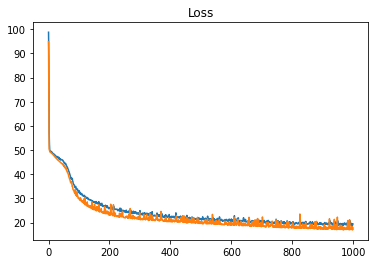

In [158]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [160]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 17.13%


In [161]:
# Saving model + Loading best weights.
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

Итак, простая нейронная сеть нам дала 17,3%

### Fit

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

Для начала поработаем с полем текстового описания объявления (Description). будем использовать лемматизацию с спомощью пакета pymorphy. А делее токенизируем наш текст (переведем в векторный вид)

In [162]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [163]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 808 kB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 9.4 MB/s eta 0:00:01


In [164]:
import pymorphy2

In [165]:
!pip install pymystem3
!pip install --upgrade pip

In [170]:
import nltk
from pymystem3 import Mystem
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [174]:
data.description = data.description.apply(lambda x: lemmatize(x))
data.description[5]

'добрый день продавать свой автомобиль перекуп не беспокоить продать только реальный покупатель кто быть ездить на она автомобиль продавать неспешно по птс два владелец сначала приобретаться автомобиль на компания пробег на автомобиль реальный полностью отбегана я быть один мелкий дтп меняться задний бампер автомобиль состояние автомобиль идеальный всё в родный краска с момент приобретение морда автомобиль сразу затянуть в плёнка антигравийный лобовой и боковой стекло в поляризационный плёнка задний обычный тонировка автомобиль обработать стеклокерамика автомобиль гаражный хранение пробег дом работа везде подземный паркинг богатый комплектация автомобиль такой на рынок нету индивидуалка при заказ автомобиль через импортёр согласовывать дополнительный опция к м пакет машина собрать в германия автомобиль стоить млн если сейчас собирать подобный комплектация стоимость по конфигрутатор стоимость млн руб более подробно по тело'

In [175]:
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [176]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

### Tokenizer

In [177]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


In [178]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'автомобиль': 5,
 'на': 6,
 'не': 7,
 'по': 8,
 'система': 9,
 'всё': 10,
 'пробег': 11,
 'задний': 12,
 'салон': 13,
 'сидение': 14,
 'год': 15,
 'состояние': 16,
 'для': 17,
 'передний': 18,
 'машина': 19,
 'от': 20,
 'до': 21,
 'при': 22,
 'диск': 23,
 'у': 24,
 'комплект': 25,
 'дилер': 26,
 'новый': 27,
 'официальный': 28,
 'без': 29,
 'ваш': 30,
 'кредит': 31,
 'вы': 32,
 'фара': 33,
 'авто': 34,
 'быть': 35,
 'руль': 36,
 'пакет': 37,
 'колесо': 38,
 'безопасность': 39,
 'комплектация': 40,
 'за': 41,
 'гарантия': 42,
 'птс': 43,
 'обмен': 44,
 'контроль': 45,
 'то': 46,
 'зеркало': 47,
 'проверка': 48,
 'из': 49,
 'покупка': 50,
 'весь': 51,
 'два': 52,
 'продажа': 53,
 'водитель': 54,
 'более': 55,
 'полный': 56,
 'есть': 57,
 'шина': 58,
 'км': 59,
 'датчик': 60,
 'отличный': 61,
 'пассажир': 62,
 'двигатель': 63,
 'так': 64,
 'резина': 65,
 'мы': 66,
 'условие': 67,
 'владелец': 68,
 'только': 69,
 'ключ': 70,
 'один': 71,
 'хороший': 72,

In [179]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.18 s


In [180]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

• автомобиль проверить по пункт • автокредит по специальный ставка от ауди центр север официальный дилер входящий в группа компания рольф и являться один из крупный дилер в европа предлагать вы ряд услуга по покупка и продажа автомобиль с пробег на протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер в россия и предоставлять клиент самый большой выбор автомобиль с пробег и другой марка каждый автомобиль проходить тщательный диагностик и подготовка и гарантировать находиться в отличный состояние чтобы убедиться в правильный выбор у вы есть возможность пройти тест драйв ― ознакомительный поездка на интересовать автомобиль вы смочь ознакомиться с автомобиль не выходить из дом – наш менеджер провести презентация и в видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условие специалист компания подобрать для вы хороший условие кредитование

### RNN NLP

Создаем 1-й вход для 

In [181]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [182]:
# Creating a neural network.
model_mlp = Sequential()

model_mlp.add(L.Dense(
    512, 
    input_dim=X_train.shape[1], 
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="elu"
))
#model.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.5))

model_mlp.add(L.Dense(
    256,
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="elu"
))

model_mlp.add(L.Dropout(0.5))

model_mlp.add(L.Dense(1, activation="linear"))

### Multiple Inputs NN

In [188]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [189]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3673856     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dense_31_input (InputLayer)     [(None, 388)]        0                                            
_______________________________________________________________________________________

### Fit

In [190]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [196]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.00001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [197]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/1000
12/12 [==============================] - ETA: 0s - loss: 26.8197 - MAPE: 26.81 - ETA: 1s - loss: 27.2939 - MAPE: 27.29 - ETA: 1s - loss: 26.6213 - MAPE: 26.61 - ETA: 1s - loss: 26.9822 - MAPE: 26.98 - ETA: 1s - loss: 26.7645 - MAPE: 26.76 - ETA: 1s - loss: 26.6249 - MAPE: 26.62 - ETA: 1s - loss: 26.5302 - MAPE: 26.52 - ETA: 0s - loss: 26.6989 - MAPE: 26.69 - ETA: 0s - loss: 26.5377 - MAPE: 26.53 - ETA: 0s - loss: 26.5917 - MAPE: 26.59 - ETA: 0s - loss: 26.5854 - MAPE: 26.58 - ETA: 0s - loss: 26.6089 - MAPE: 26.60 - 3s 237ms/step - loss: 26.6089 - MAPE: 26.6075 - val_loss: 26.3746 - val_MAPE: 26.3732
Epoch 2/1000
12/12 [==============================] - ETA: 0s - loss: 28.4918 - MAPE: 28.49 - ETA: 1s - loss: 27.9527 - MAPE: 27.95 - ETA: 1s - loss: 27.6041 - MAPE: 27.60 - ETA: 1s - loss: 27.9632 - MAPE: 27.96 - ETA: 1s - loss: 27.5173 - MAPE: 27.51 - ETA: 1s - loss: 27.6381 - MAPE: 27.63 - ETA: 0s - loss: 27.3710 - MAPE: 27.36 - ETA: 0s - loss: 27.3418 - MAPE: 27.34 - ETA: 0

x

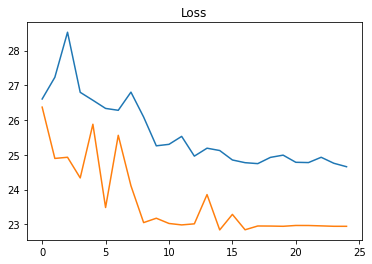

In [198]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [199]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [200]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 22.94%


Получили результат 22,94%

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

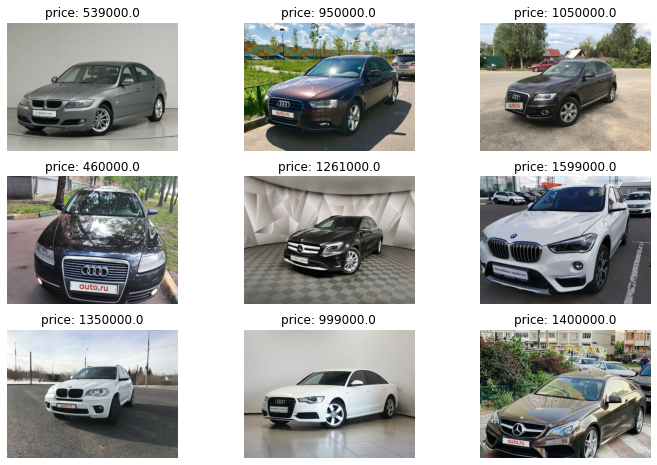

In [201]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [202]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

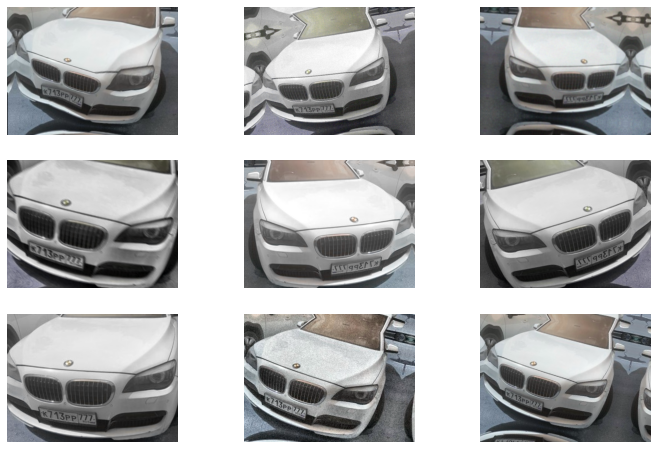

In [203]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [204]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [205]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [206]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [207]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 0us/step


In [212]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential()

tabular_model.add(L.Dense(
    512, 
    input_dim=X_train.shape[1], 
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="elu"
))
#model.add(L.BatchNormalization())
tabular_model.add(L.Dropout(0.5))

tabular_model.add(L.Dense(
    256,
    kernel_regularizer=regularizers.l1_l2(
        l1=0.000000001, 
        l2=0.000000001
    ), 
    activation="elu"
))

tabular_model.add(L.Dropout(0.5))

tabular_model.add(L.Dense(1, activation="linear"))

In [213]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [214]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [215]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [216]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.00001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [217]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - ETA: 0s - loss: 99.9999 - MAPE: 99.99 - ETA: 1:01 - loss: 99.9934 - MAPE: 99.99 - ETA: 1:22 - loss: 99.9834 - MAPE: 99.98 - ETA: 1:30 - loss: 99.9696 - MAPE: 99.96 - ETA: 1:35 - loss: 99.9520 - MAPE: 99.95 - ETA: 1:38 - loss: 99.9263 - MAPE: 99.92 - ETA: 1:40 - loss: 99.8830 - MAPE: 99.88 - ETA: 1:42 - loss: 99.8230 - MAPE: 99.82 - ETA: 1:42 - loss: 99.7359 - MAPE: 99.73 - ETA: 1:42 - loss: 99.6533 - MAPE: 99.65 - ETA: 1:43 - loss: 99.5444 - MAPE: 99.54 - ETA: 1:43 - loss: 99.3781 - MAPE: 99.37 - ETA: 1:42 - loss: 99.1411 - MAPE: 99.14 - ETA: 1:42 - loss: 98.9403 - MAPE: 98.94 - ETA: 1:43 - loss: 98.7339 - MAPE: 98.73 - ETA: 1:43 - loss: 98.4442 - MAPE: 98.44 - ETA: 1:42 - loss: 98.0317 - MAPE: 98.03 - ETA: 1:42 - loss: 97.7288 - MAPE: 97.72 - ETA: 1:41 - loss: 97.1503 - MAPE: 97.15 - ETA: 1:41 - loss: 96.5606 - MAPE: 96.56 - ETA: 1:40 - loss: 95.8269 - MAPE: 95.82 - ETA: 1:40 - loss: 94.8936 - MAPE: 94.89 - ETA: 1:39 - loss: 93.89

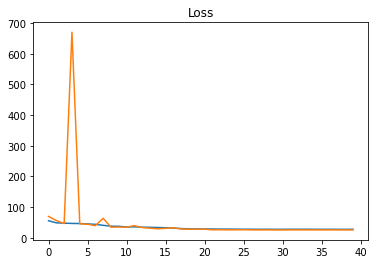

In [218]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [219]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 25.76%


Получили результат 25.76%

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

##  применим fine-tuning **

In [222]:
# Loading the model.
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3)
)

efficientnet_output = L.GlobalAveragePooling2D()(
    efficientnet_model.output
)

In [223]:
fine_tune_at = len(efficientnet_model.layers)//2

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [224]:
# Creating a tabular NN.
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [225]:
# Creating a NLP NN.
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [226]:
# Combining the networks and head installing.
combinedInput = L.concatenate([
    efficientnet_output, 
    tabular_model.output, 
    nlp_model.output
])

head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[
    efficientnet_model.input, 
    tabular_model.input, 
    nlp_model.input
], outputs=head)

In [230]:
optimizer = tf.keras.optimizers.Adam(0.005)

model.compile(
    loss='MAPE',
    optimizer=optimizer,
    metrics=['MAPE']
)

In [231]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=3, restore_best_weights=True,)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]


In [232]:
history = model.fit(train_dataset.batch(30),
                    epochs=50,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

Epoch 1/50
190/190 [==============================] - ETA: 0s - loss: 100.0014 - MAPE: 100.00 - ETA: 33s - loss: 99.9587 - MAPE: 99.9587 - ETA: 52s - loss: 99.8939 - MAPE: 99.893 - ETA: 54s - loss: 99.7998 - MAPE: 99.799 - ETA: 54s - loss: 99.6664 - MAPE: 99.666 - ETA: 58s - loss: 99.4688 - MAPE: 99.468 - ETA: 1:02 - loss: 99.1291 - MAPE: 99.12 - ETA: 1:05 - loss: 98.6289 - MAPE: 98.62 - ETA: 1:10 - loss: 97.7910 - MAPE: 97.79 - ETA: 1:08 - loss: 97.0444 - MAPE: 97.04 - ETA: 1:08 - loss: 96.0798 - MAPE: 96.07 - ETA: 1:11 - loss: 94.5833 - MAPE: 94.58 - ETA: 1:12 - loss: 92.5528 - MAPE: 92.55 - ETA: 1:10 - loss: 90.7877 - MAPE: 90.78 - ETA: 1:08 - loss: 89.0100 - MAPE: 89.01 - ETA: 1:09 - loss: 86.8873 - MAPE: 86.88 - ETA: 1:11 - loss: 84.7258 - MAPE: 84.72 - ETA: 1:11 - loss: 83.0903 - MAPE: 83.09 - ETA: 1:11 - loss: 81.5761 - MAPE: 81.57 - ETA: 1:10 - loss: 79.6260 - MAPE: 79.62 - ETA: 1:09 - loss: 78.6063 - MAPE: 78.60 - ETA: 1:10 - loss: 77.4461 - MAPE: 77.44 - ETA: 1:10 - loss: 77.

Получили значение 23.81%


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Выводы

В рамках работы были использованы большинство предложенией по улучшению модели. Дополнительно были рассмотрены механизмы autoML различных библиотек.

Итого наилучший результат получился обычным ML способом (AutoML) при этом это заняло на порядок меньше времени, чем построение сложной нейросети.

# Blend

In [234]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 14.94%


In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [237]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [238]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [239]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [240]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_57_input (InputLayer)     [(None, 388)]        0                                            
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 512)          199168      dense_57_input[0][0]             
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 512)          0           dense_57[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [241]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [242]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 100.0016 - MAPE: 100.00 - 0s 20ms/step - loss: 88.0192 - MAPE: 88.0192 - val_loss: 50.0967 - val_MAPE: 50.0967
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 50.0513 - MAPE: 50.05 - 0s 8ms/step - loss: 53.5681 - MAPE: 53.5681 - val_loss: 52.9947 - val_MAPE: 52.9947
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 53.8009 - MAPE: 53.80 - 0s 8ms/step - loss: 50.5453 - MAPE: 50.5453 - val_loss: 49.1072 - val_MAPE: 49.1072
Epoch 4/500
12/12 [==============================] - ETA: 0s - loss: 48.1602 - MAPE: 48.16 - 0s 8ms/step - loss: 49.4455 - MAPE: 49.4455 - val_loss: 48.9977 - val_MAPE: 48.9977
Epoch 5/500
12/12 [==============================] - ETA: 0s - loss: 50.9178 - MAPE: 50.91 - 0s 8ms/step - loss: 48.9744 - MAPE: 48.9744 - val_loss: 48.5813 - val_MAPE: 48.5813
Epoch 6/500
12/12 [==============================] - ETA: 0s - loss: 50.8265 - MAPE: 50.82 - 0s 8ms/step - loss:

In [243]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 30.44%


In [ ]:
# 